### 导入库

In [1]:
from torch.utils.data import TensorDataset, DataLoader, random_split
import numpy as np
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim
import matplotlib.pyplot as plt
from DRSNet import DRSNet34
from data_process import preprocess

print(torch.__version__)
print(torch.cuda.is_available())

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 4, 2048, 1]              12
       BatchNorm2d-2           [-1, 4, 2048, 1]               8
              ReLU-3           [-1, 4, 2048, 1]               0
            Conv2d-4           [-1, 4, 2048, 1]              48
       BatchNorm2d-5           [-1, 4, 2048, 1]               8
              ReLU-6           [-1, 4, 2048, 1]               0
            Conv2d-7           [-1, 4, 2048, 1]              48
       BatchNorm2d-8           [-1, 4, 2048, 1]               8
 AdaptiveAvgPool2d-9              [-1, 4, 1, 1]               0
AdaptiveAvgPool2d-10              [-1, 4, 1, 1]               0
           Linear-11                    [-1, 4]              20
           Linear-12                    [-1, 4]              20
      BatchNorm1d-13                    [-1, 4]               8
      BatchNorm1d-14                   

$$
时间长度(秒) = \frac{采样点数}{采样频率}
$$

In [2]:
# 定义数据文件所在的路径，使用原始字符串避免反斜杠转义问题
path = r"C:\Users\Administrator\Desktop\阅读文献\具体算法\算法代码\振动信号\data\data_snr-5"

# 标记数据的类型或来源
data_mark = "DE"
# 设置采样频率，单位为赫兹（Hz）
fs = 12000
# 计算窗口的时间长度，单位为秒
win_tlen = 2048 / 12000
# 计算窗口重叠率，单位为百分比
overlap_rate = (0 / 2048) * 100
# 设置随机数种子，确保代码中涉及随机数生成的部分结果可复现
random_seed = 1
# 设置训练时每个批次包含的样本数量
batch_size = 16
# 设置训练的轮数，即整个数据集被模型遍历的次数
num_epochs = 10

In [3]:
# 调用 preprocess 函数对数据进行预处理，传入路径、数据标记、采样频率、窗口时间长度、重叠率和随机种子
# 返回处理后的特征数据 X 和标签数据 y
X, y = preprocess(path, data_mark, fs, win_tlen, overlap_rate, random_seed)
# 计算处理后特征数据的长度
len_data = len(X)
# 打印特征数据的长度
print(len_data)
# 将特征数据 X 重塑为适合模型输入的形状，即 (样本数量, 通道数, 时间步长, 特征维度)
X = X.reshape(len_data, 1, 2048, 1)
# 将 numpy 数组类型的特征数据转换为 PyTorch 张量
train_data = torch.from_numpy(X)
# 将 numpy 数组类型的标签数据转换为 PyTorch 张量
train_label = torch.from_numpy(y)
# 创建一个 TensorDataset 对象，将特征数据和标签数据组合在一起
train_dataset = TensorDataset(train_data, train_label)

# 计算训练集、测试集的样本数量，分别占总数据集的 70% 和 30%
train_size = int(len_data * 0.7)
test_size = len_data - train_size
# 使用 random_split 函数将数据集随机划分为训练集和测试集
train_dataset, test_dataset = random_split(train_dataset, [train_size, test_size])

# 创建训练集的数据加载器，设置批次大小、是否打乱数据和是否丢弃最后一个不完整的批次
train_data_loader = DataLoader(
    dataset=train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
# 创建测试集的数据加载器，设置批次大小、是否打乱数据和是否丢弃最后一个不完整的批次
test_data_loader = DataLoader(
    dataset=test_dataset, batch_size=batch_size, shuffle=True, drop_last=True)

-> 数据位置:C:\Users\Administrator\Desktop\阅读文献\具体算法\算法代码\振动信号\data\data_snr-5
-> 原始数据采样频率:12000Hz,
-> 数据增强后共有：413条,
-> 单个数据长度：2048采样点,
-> 重叠量:0个采样点,
-> 类别数据数目: [(0, 236), (1, 59), (2, 59), (3, 59)]
413


In [4]:
# 实例化一个 DRSNet34 模型
net = DRSNet34().to('cpu')
# 将模型移动到 GPU 上进行训练（如果可用的话），否则使用 CPU
if torch.cuda.is_available():
    net = net.cuda()

# 用于存储每个 epoch 的训练损失
Loss_list = []
# 用于存储每个 epoch 的训练准确率
Accuracy_list = []
# 用于存储每个 epoch 的测试准确率
acc = []
# 定义优化器，使用随机梯度下降（SGD）优化器
# 传入模型的参数，设置学习率为 0.01，动量为 0.9，权重衰减为 5e-4
optimizer = optim.SGD(net.parameters(), lr=0.01,
                      momentum=0.9, weight_decay=5e-4)
# 定义损失函数，使用交叉熵损失函数
loss_function = nn.CrossEntropyLoss()
# 开始训练循环，训练 num_epochs 个 epoch
for epoch in range(num_epochs):
    # 将模型设置为训练模式
    net.train()
    # 初始化训练过程中的总损失
    sum_loss = 0.0
    # 初始化预测正确的样本数量
    correct = 0.0
    # 初始化训练样本的总数
    total = 0.0
    # 遍历训练数据加载器中的每个批次
    for i, (X, y) in enumerate(train_data_loader):
        # 获取训练数据加载器的总批次数量
        length = len(train_data_loader)
        # 将输入数据转换为 CUDA 浮点型张量
        X = X.type(torch.cuda.FloatTensor)
        # 将标签数据转换为 CUDA 长整型张量
        y = y.type(torch.cuda.LongTensor)
        # y = y.type(torch.cuda.FloatTensor)

        # 清空优化器中的梯度信息
        optimizer.zero_grad()
        # 前向传播，计算模型的输出
        outputs = net(X)
        # 计算损失
        loss = loss_function(outputs, y)
        # 反向传播，计算梯度
        loss.backward()
        # 更新模型参数
        optimizer.step()

        # 累加损失
        sum_loss += loss.item()
        # 获取预测结果中概率最大的类别索引
        _, predicted = torch.max(outputs.data, 1)
        # 累加样本总数
        total += y.size(0)
        # 累加预测正确的样本数
        correct += predicted.eq(y.data).cpu().sum()
        # 打印当前 epoch、迭代次数、损失和准确率
        print('[epoch:%d, iter:%d/%d] Loss: %.03f | Acc: %.3f%% '
              % (epoch + 1, (i + 1), length, sum_loss / (i + 1), 100. * correct / total))
    # 将当前 epoch 的平均损失添加到损失列表中
    Loss_list.append(sum_loss / (len(train_data_loader)))
    # 将当前 epoch 的训练准确率添加到准确率列表中
    Accuracy_list.append(correct / total)

    print("Waiting Test!")
    # 不计算梯度，节省计算资源
    with torch.no_grad():
        # 初始化测试过程中预测正确的样本数量
        correct = 0
        # 初始化测试样本的总数
        total = 0
        # 遍历测试数据加载器中的每个批次
        for test_i, (test_X, test_y) in enumerate(test_data_loader):
            # 将模型设置为评估模式
            net.eval()
            # 将测试输入数据转换为 CUDA 浮点型张量
            X = test_X.type(torch.cuda.FloatTensor)
            # 将测试标签数据转换为 CUDA 长整型张量
            y = test_y.type(torch.cuda.LongTensor)
            # 前向传播，计算模型的输出
            outputs = net(X)
            # 获取预测结果中概率最大的类别索引
            _, predicted = torch.max(outputs.data, 1)
            # 累加样本总数
            total += y.size(0)
            # 累加预测正确的样本数
            correct += (predicted == y).sum().item()
            # 当测试了 100 个批次后，停止测试
            if test_i == 100:
                break
        # 打印测试集的分类准确率
        print('测试分类准确率为：{}%'.format(round(100 * correct / total, 3)))
        # 将当前 epoch 的测试准确率添加到测试准确率列表中
        acc.append(100. * correct / total)

[epoch:1, iter:1/18] Loss: 1.291 | Acc: 62.500% 
[epoch:1, iter:2/18] Loss: 1.301 | Acc: 62.500% 
[epoch:1, iter:3/18] Loss: 1.278 | Acc: 62.500% 
[epoch:1, iter:4/18] Loss: 1.284 | Acc: 57.812% 
[epoch:1, iter:5/18] Loss: 1.248 | Acc: 58.750% 
[epoch:1, iter:6/18] Loss: 1.244 | Acc: 57.292% 
[epoch:1, iter:7/18] Loss: 1.221 | Acc: 57.143% 
[epoch:1, iter:8/18] Loss: 1.197 | Acc: 57.812% 
[epoch:1, iter:9/18] Loss: 1.176 | Acc: 58.333% 
[epoch:1, iter:10/18] Loss: 1.135 | Acc: 60.625% 
[epoch:1, iter:11/18] Loss: 1.171 | Acc: 57.955% 
[epoch:1, iter:12/18] Loss: 1.176 | Acc: 57.292% 
[epoch:1, iter:13/18] Loss: 1.152 | Acc: 58.654% 
[epoch:1, iter:14/18] Loss: 1.141 | Acc: 58.929% 
[epoch:1, iter:15/18] Loss: 1.126 | Acc: 59.167% 
[epoch:1, iter:16/18] Loss: 1.131 | Acc: 58.594% 
[epoch:1, iter:17/18] Loss: 1.130 | Acc: 58.088% 
[epoch:1, iter:18/18] Loss: 1.129 | Acc: 57.639% 
Waiting Test!
测试分类准确率为：56.25%
[epoch:2, iter:1/18] Loss: 0.634 | Acc: 81.250% 
[epoch:2, iter:2/18] Loss: 0.8

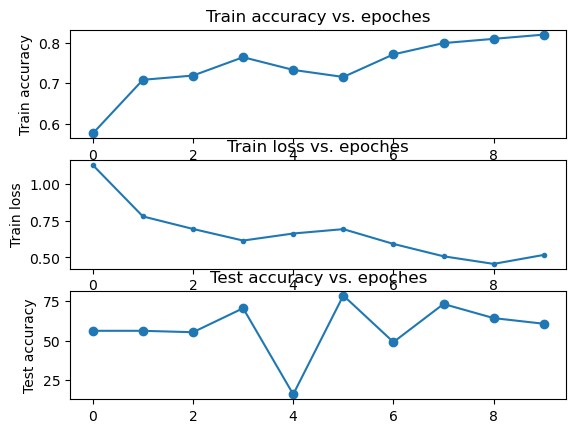

Training Finished, TotalEPOCH=10


In [5]:
x1 = range(0, num_epochs)
x2 = range(0, num_epochs)
x3 = range(0, num_epochs)
y1 = Accuracy_list
y2 = Loss_list
y3 = acc

plt.subplot(3, 1, 1)
plt.plot(x1, y1, 'o-')
plt.title('Train accuracy vs. epoches')
plt.ylabel('Train accuracy')
plt.subplot(3, 1, 2)
plt.plot(x2, y2, '.-')
plt.title('Train loss vs. epoches')
plt.ylabel('Train loss')
plt.subplot(3, 1, 3)
plt.plot(x3, y3, 'o-')
plt.title('Test accuracy vs. epoches')
plt.ylabel('Test accuracy')
plt.show()
# print(Accuracy_list)
print("Training Finished, TotalEPOCH=%d" % num_epochs)